## Glass Classification

This is a Glass Identification Data Set from UCI. It contains 10 attributes including id. The response is glass type(discrete 7 values)
https://www.kaggle.com/uciml/glass
### Content
Attribute Information:

Id number: 1 to 214 (removed from CSV file)                                                                      
RI: refractive index                                                                                                          
Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)                                  
Mg: Magnesium                                                                                                                   
Al: Aluminum                                                                                                                  
Si: Silicon                                                                              
K: Potassium                                                                              
Ca: Calcium                                                                              
Ba: Barium                                                                              
Fe: Iron                                                                              
Type of glass: (class attribute) -- 1 building_windows_float_processed -- 2 building_windows_non_float_processed -- 3 vehicle_windows_float_processed -- 4 vehicle_windows_non_float_processed (none in this database) -- 5 containers -- 6 tableware -- 7 headlamps

In [158]:
import numpy as np
import pandas as pa
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
import squarify
from sklearn.utils import shuffle
from scipy.special import boxcox1p
from scipy.stats import boxcox


from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

color = sn.color_palette()
sn.set_style('darkgrid')
import matplotlib.style as style
#style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'

In [27]:
glass_data = pa.read_csv('glass.csv')
glass_data = shuffle(glass_data)
print("Glass data has total {} data".format(len(glass_data)))

Glass data has total 214 data


In [28]:
train_data = glass_data[0:205]
test_data = glass_data[205:]
glass_data = train_data

### Descriptive Analytics

In [29]:
glass_data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,1.518384,13.396488,2.669366,1.443756,72.659951,0.497561,8.968293,0.182732,0.055024,2.770732
std,0.003069,0.826352,1.451027,0.505686,0.778492,0.663674,1.431519,0.506678,0.094716,2.128500
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516530,12.890000,1.880000,1.190000,72.320000,0.120000,8.270000,0.000000,0.000000,1.000000
50%,1.517660,13.270000,3.480000,1.360000,72.810000,0.560000,8.600000,0.000000,0.000000,2.000000
75%,1.519160,13.800000,3.600000,1.620000,73.100000,0.610000,9.180000,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [30]:
type_data = glass_data['Type'].value_counts()
type_data = type_data.sort_index(axis=0)
type_data = pa.DataFrame({'Count':type_data.values,'Label':type_data.index})
type_data.index = ['building_windows_float_processed','building_windows_non_float_processed',
                   'vehicle_windows_float_processed','containers',
                   'tableware','headlamps']

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

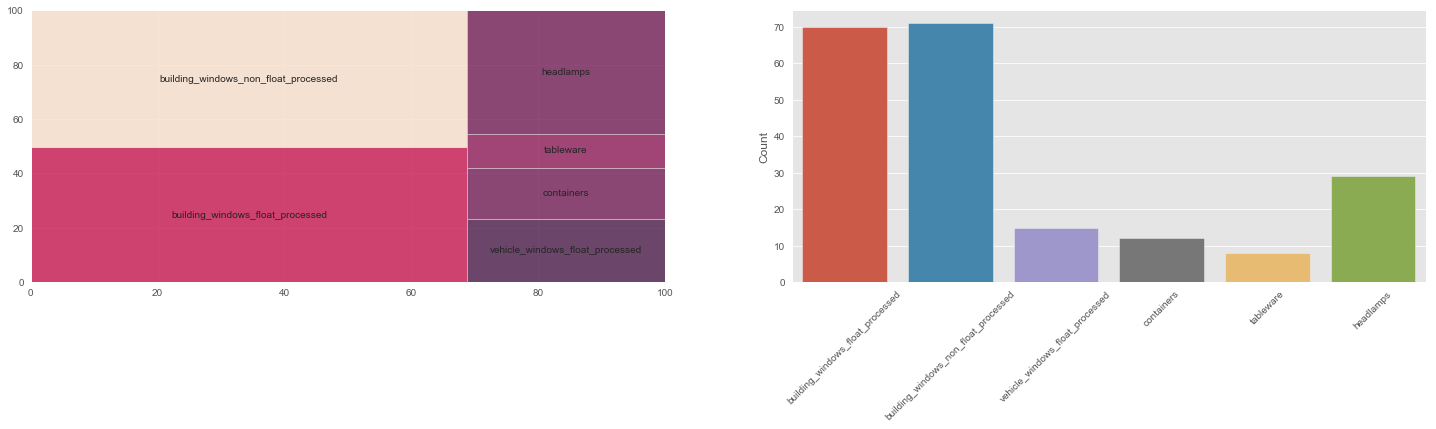

In [31]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(25,5))
squarify.plot(sizes=type_data.Count, label=type_data.index, alpha=.8,ax=axis1)
sn.barplot(x=type_data.index,y='Count',data=type_data,ax=axis2)
plt.xticks(rotation='45')

#### Draw box plot for all the numeric features to understand if there is any outliers and check the variablity of the data 

In [32]:
features = list(glass_data.columns)
features.remove('Type')

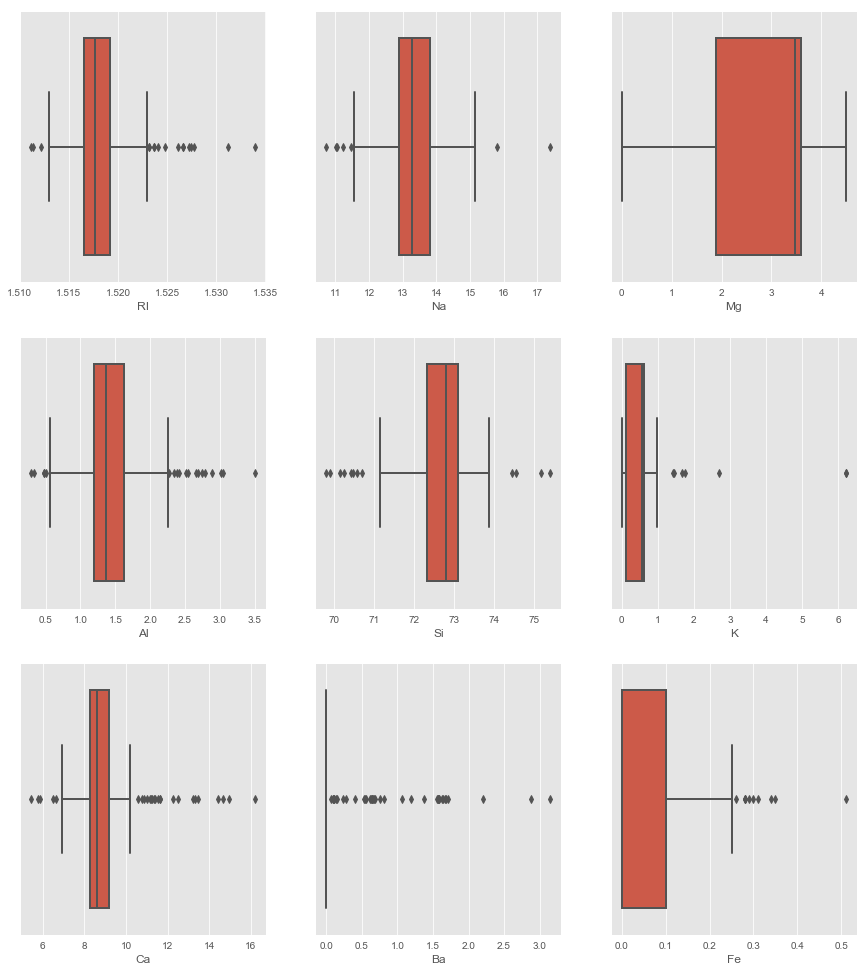

In [33]:
plt.figure(figsize=(15,17))

for i in range(1, 10):
    plt.subplot(3, 3, i)
    sn.boxplot(glass_data[features[i-1]])

In [34]:
from collections import Counter
def get_ouliers(data):
    outliers = []
    
    # iterate over features(columns)
    for col in data.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(data[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(data[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_range = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outliers_values = data[(data[col] < Q1 - outlier_range) | (data[col] > Q3 + outlier_range)].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outliers.extend(outliers_values)
        
    # select observations containing more than 2 outliers
    #print(outliers)
    outliers = Counter(outliers)
    #print(outliers)
    multiple_outliers = list( k for k, v in outliers.items() if v > 3 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(get_ouliers(glass_data[features]))))   

The dataset contains 6 observations with more than 2 outliers


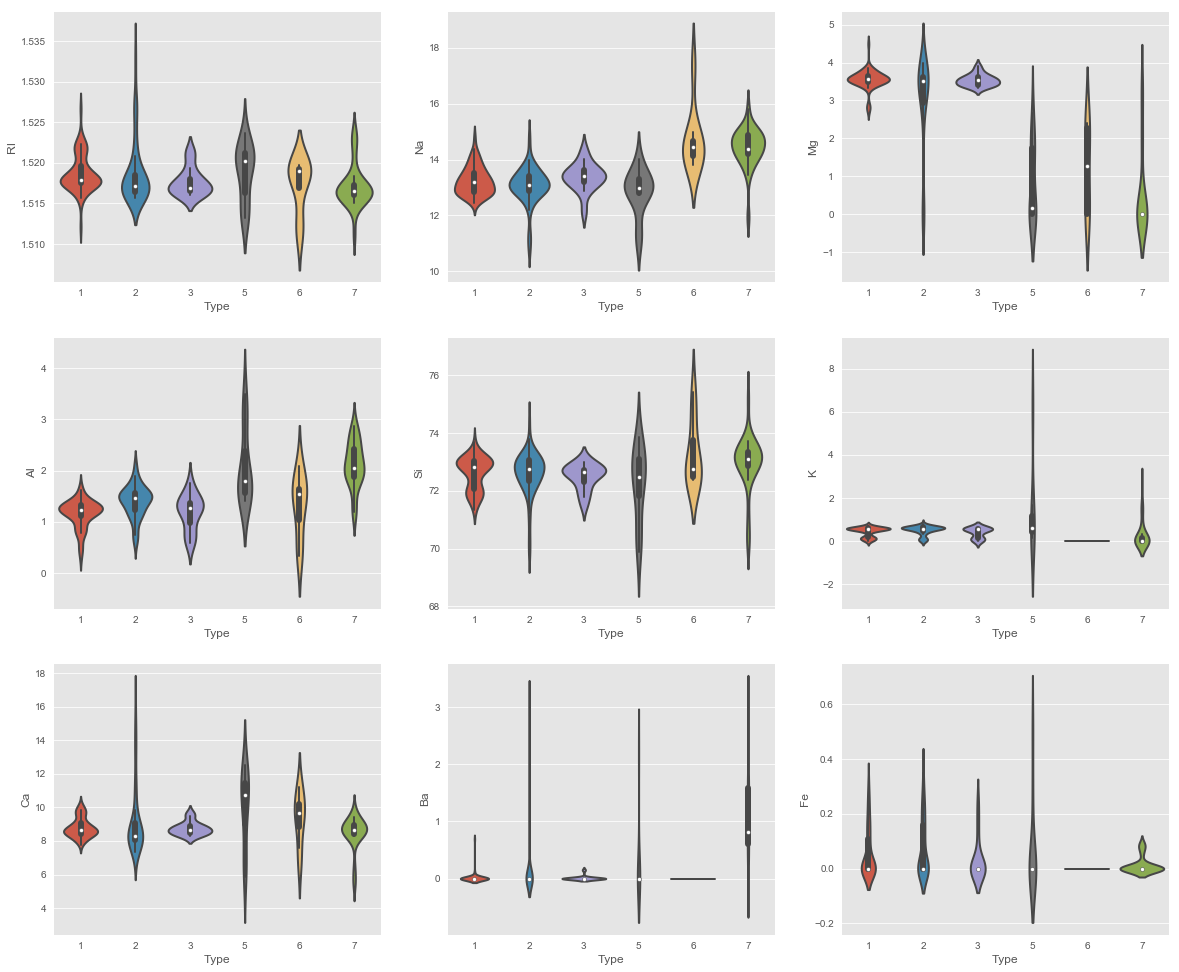

In [35]:
plt.figure(figsize=(20,17))

for i in range(1, 10):
    ax=plt.subplot(3, 3, i)
    ax=sn.violinplot(x='Type',y=glass_data[features[i-1]],data=train_data)

###### Lets check how the data is related and scattered using pairplot 

<Figure size 1080x504 with 0 Axes>

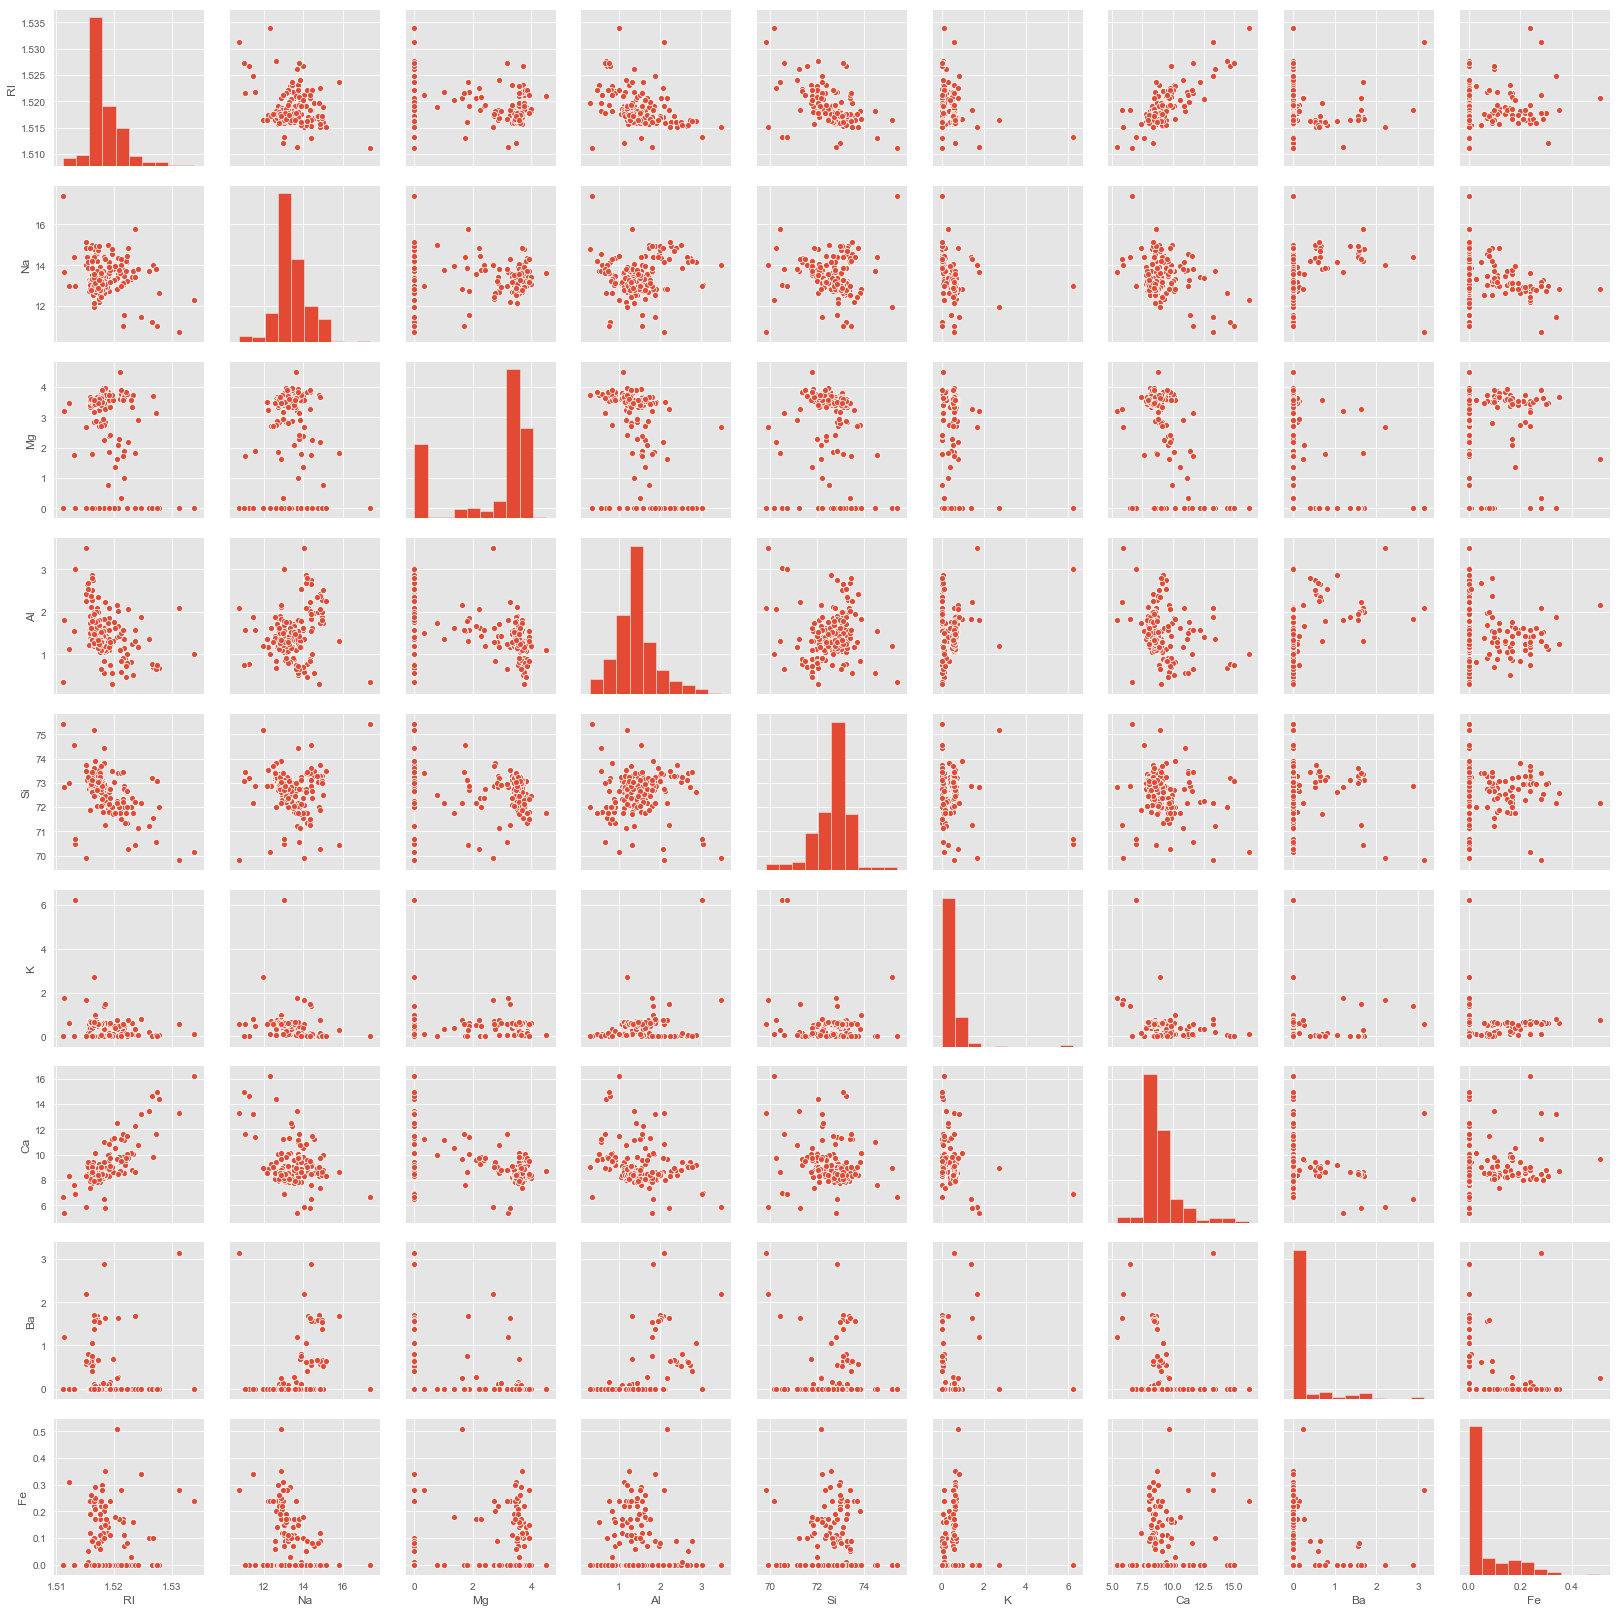

In [36]:
plt.figure(figsize=(15,7))
sn.pairplot(glass_data[features])

It can be seen that Ri and Ca has a strong positive relation among each other

#### Let's check the co-relation between each items for better understanding

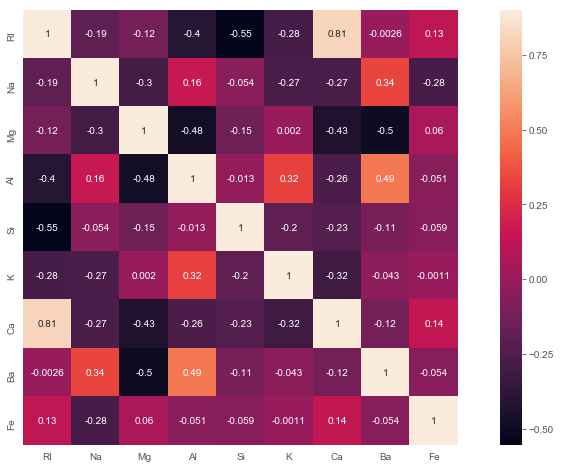

In [37]:
corr  = glass_data[features].corr()
plt.figure(figsize=(15,8))
sn.heatmap(corr,annot=True,vmax=0.9, square=True)

 Here we can see there is no multico-liearity among features (I am chossing a cut-off -> 0.9) 

### Data Transformation

#### Remove the ouliers

In [38]:
outliers_index = get_ouliers(glass_data[features])
glass_data = glass_data.drop(outliers_index)

In [39]:
#glass_data = pa.concat([train_data,test_data])
#glass_data = glass_data.reset_index()
#glass_data = glass_data.drop('index',axis=1)

#### Check the distribution of each numerical features and check it's skewness and kurtosis values

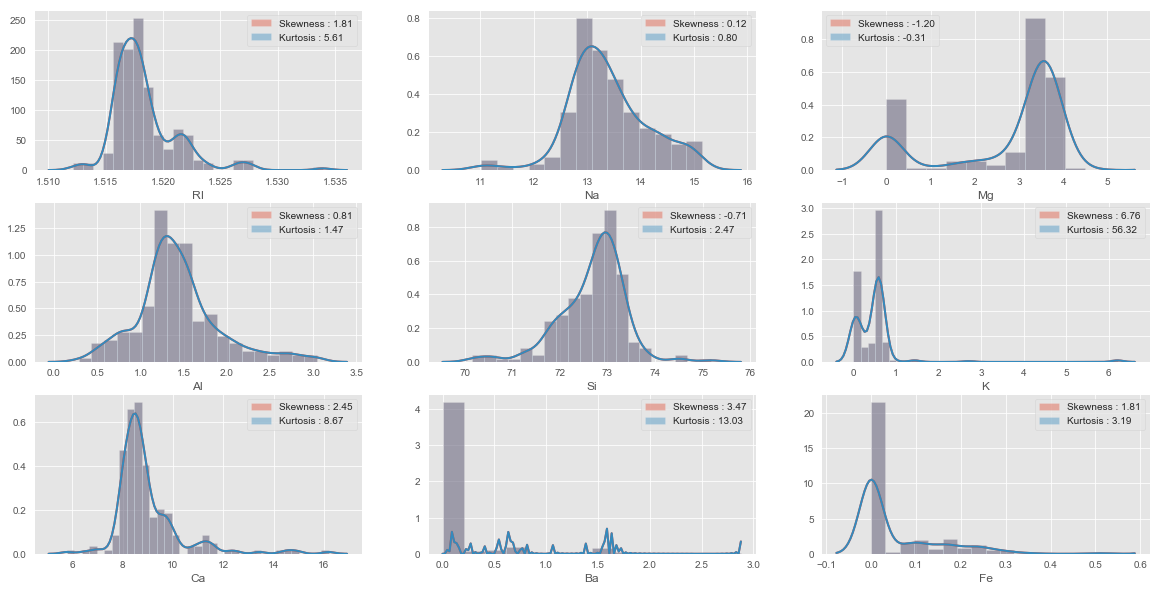

In [40]:
plt.figure(figsize=(20,10))

for i in range(1, 10):
    ax=plt.subplot(3, 3, i)
    ax=sn.distplot(glass_data[features[i-1]],label='Skewness : %.2f'%glass_data[features[i-1]].skew())
    ax=sn.distplot(glass_data[features[i-1]],label='Kurtosis : %.2f'%glass_data[features[i-1]].kurtosis())

    plt.legend(loc='best')

Here we can see no features are normally distriburted so we have to transform this data I am using box cox transfomation for this  

In [41]:
features_boxcox = []
for feature in features:
    bc_transformed, _ = boxcox(glass_data[feature]+1) 
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
new_data = pa.DataFrame(data=features_boxcox, columns=features)
new_data['Type'] = glass_data['Type']

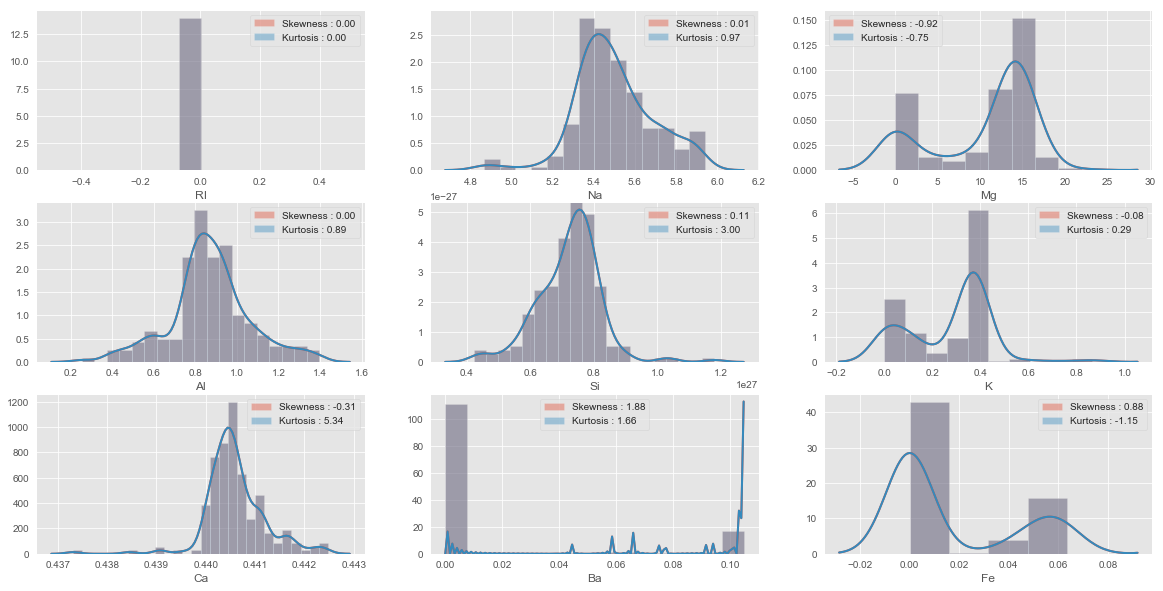

In [42]:
plt.figure(figsize=(20,10))

for i in range(1, 10):
    ax=plt.subplot(3, 3, i)
    ax=sn.distplot(new_data[features[i-1]],label='Skewness : %.2f'%new_data[features[i-1]].skew())
    ax=sn.distplot(new_data[features[i-1]],label='Kurtosis : %.2f'%new_data[features[i-1]].kurtosis())

    plt.legend(loc='best')

Here we can see that box cox transformation performed well in reducing the skewness but most of features is still skewed. If we compare this with standard scaler,  standard scaler performd way much better in accuracy so I will be appplying standard scaler for normalizing the features.

### Modelling

In [223]:
X = glass_data[features]
y = glass_data['Type']

In [224]:
random_state = 5
X_train,x_test,Y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [225]:
y_test.value_counts()

1    15
2    11
3     7
7     4
6     2
5     1
Name: Type, dtype: int64

In [226]:
results = pa.DataFrame(columns=['Model','Para','Test_Score','CV_Mean','CV_STD'])
ensemble_models ={}

In [227]:
def save(model,name):
    global results
    
    model.best_estimator_.fit(X_train,Y_train)
    scores = cross_val_score(model.best_estimator_,X_train,Y_train,cv=3,scoring='accuracy',verbose = 0)
    
    scores_mean = scores.mean()
    scores_std = scores.std()
    
    test_score =model.score(x_test,y_test)
    
    results = results.append({'Model':name,'Para':model.best_params_,'Test_Score':test_score,'CV_Mean':scores_mean,
                              'CV_STD':scores_std},ignore_index=True)
    ensemble_models[name] = model.best_estimator_
    
    #Print Evaluation
    print("\nEvalutaion Method:{}".format('accuracy'))
    print("Optimal Model Parameters {}".format(model.best_params_))
    print("Train CV accuracy: %0.2f (+/- %0.2f) [%s]"%(scores_mean,scores_std,name))
    
    print("Test Score",test_score)
    
    # Confusion matrix
    model.fit(X_train, Y_train)
    pred_test = model.predict(x_test)
    cm = metrics.confusion_matrix(y_test,pred_test)
    sn.heatmap(cm,cmap='viridis',annot=True,fmt=".2f")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title('{}'.format(name))
    plt.show()

##### Logistic Regression

In [228]:
from sklearn.pipeline import Pipeline
logit =LogisticRegression()
all_steps = [('StandardScaler',StandardScaler()),('model',LogisticRegression())]
logit_model = Pipeline(all_steps)

In [229]:
parameters = { 'model__C' : [1,10,100,1000,10000],
               'model__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
               'model__max_iter' : [5000],
               'model__random_state': [random_state] 
}
logit_grid = GridSearchCV(logit_model,parameters,iid=False,verbose=1,cv=3)
logit_grid = logit_grid.fit(X_train,Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.9s finished



Evalutaion Method:accuracy
Optimal Model Parameters {'model__C': 10000, 'model__max_iter': 5000, 'model__random_state': 5, 'model__solver': 'newton-cg'}
Train CV accuracy: 0.71 (+/- 0.05) [LR]
Test Score 0.575
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.9s finished


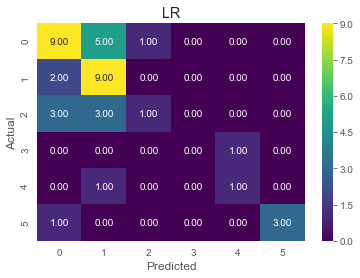

In [230]:
save(logit_grid,'LR')

##### RandomForest

In [231]:
all_steps = [('StandardScaler',StandardScaler()),('model',RandomForestClassifier())]
radm_model = Pipeline(all_steps)

In [232]:
tuned_parameters = [{'model__max_depth':[10,15,100,200,500],
                     'model__n_estimators':[10,30,40,100,500],
                     'model__max_features':['sqrt',0.2],
                     'model__criterion':['gini','entropy'],
                     'model__random_state':[random_state]}]
radm = RandomForestClassifier()
grid_radm = GridSearchCV(radm_model,tuned_parameters,iid=False,verbose=1,cv=3)
grid_radm = grid_radm.fit(X_train,Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   55.0s finished



Evalutaion Method:accuracy
Optimal Model Parameters {'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 500, 'model__random_state': 5}
Train CV accuracy: 0.76 (+/- 0.01) [RF]
Test Score 0.725
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   54.4s finished


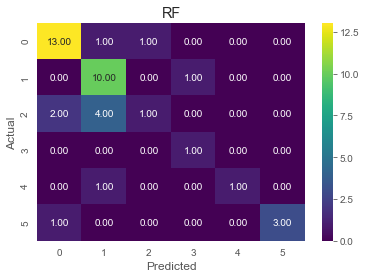

In [233]:
save(grid_radm,'RF')

##### Gradient Boosting

In [234]:
all_steps = [('StandardScaler',StandardScaler()),('model',GradientBoostingClassifier())]
grad_model = Pipeline(all_steps)

In [235]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [236]:
tuned_parameters ={'model__n_estimators': [100,200,300,500]}

grad = GradientBoostingClassifier()
grid_grad = GridSearchCV(grad_model,tuned_parameters,iid=False,verbose=1,cv=3)
grid_grad = grid_grad.fit(X_train,Y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    7.7s finished



Evalutaion Method:accuracy
Optimal Model Parameters {'model__n_estimators': 100}
Train CV accuracy: 0.69 (+/- 0.02) [GB]
Test Score 0.65
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    7.6s finished


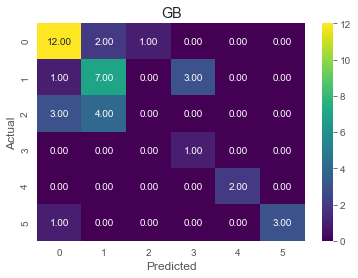

In [237]:
save(grid_grad,'GB')

In [238]:
all_steps = [('StandardScaler',StandardScaler()),('model',SGDClassifier(max_iter=5,tol=None))]
sto_grad = Pipeline(all_steps)

In [239]:
tuned_parameters ={
                   'model__loss':["hinge","log","modified_huber","epsilon_insensitive","squared_epsilon_insensitive"]
                  }

grid_sto = GridSearchCV(sto_grad,tuned_parameters,cv=3,verbose=1)

grid_sto = grid_sto.fit(X_train, Y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished



Evalutaion Method:accuracy
Optimal Model Parameters {'model__loss': 'hinge'}
Train CV accuracy: 0.57 (+/- 0.04) [SGD]
Test Score 0.525
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


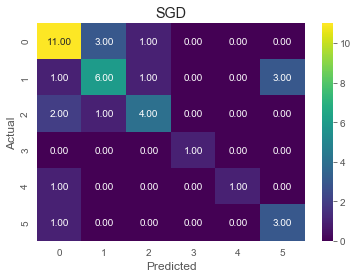

In [240]:
save(grid_sto,'SGD')

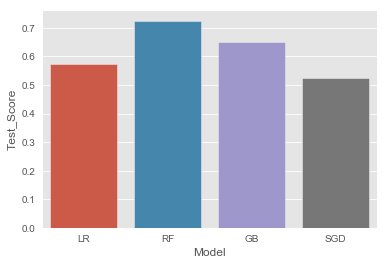

In [241]:
sn.barplot(x=results.Model,y=results.Test_Score)

From here we can see that Random Forest Performed Better than others 

##### Check the feature importance of each ensemble model

In [315]:
def feature_importance(grad,radm,sto,logit):
    model_grad= grad.best_estimator_[1]
    model_grad.fit(X_train,Y_train)
    
    model_radm= radm.best_estimator_[1]
    model_radm.fit(X_train,Y_train)
    
    feature_rank = pa.DataFrame({'feature':X_train.columns,
                                 'importance_grad':model_grad.feature_importances_,
                                 'importance_radm':model_radm.feature_importances_  
                                })
    
    plt.figure(figsize=(6,4))
    
    fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,6))
    
    feature_rank_grad = feature_rank.sort_values('importance_grad',ascending=False)
    sn.barplot(x='importance_grad',y='feature',data=feature_rank_grad, ax=axis1)
    
    
    feature_rank_radm = feature_rank.sort_values('importance_radm',ascending=False)
    
    sn.barplot(x='importance_radm',y='feature',data=feature_rank_radm, ax=axis2)


<Figure size 432x288 with 0 Axes>

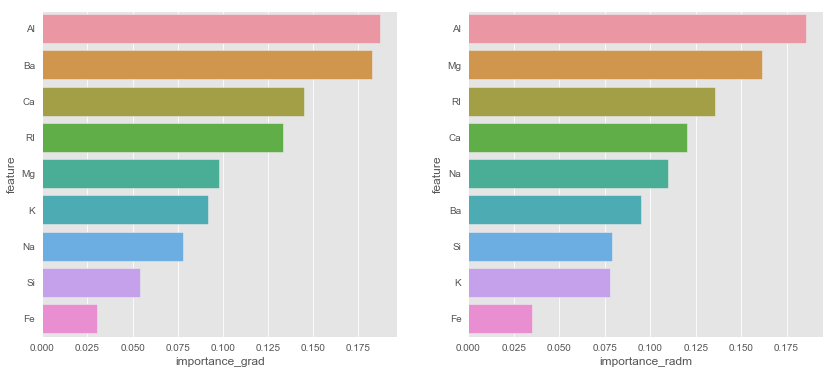

In [316]:
feature_importance(grid_grad,grid_radm,grid_sto,
        logit_grid)

So from here we can interpret that the importance is quite similer according to both the models

### Prediction on Test Data

##### Classification report on test data using Random Forest as It performed best

In [322]:
actual_test = test_data['Type']
y_test = test_data[features]

In [324]:
pred_test = grid_radm.predict(y_test)

In [339]:
from sklearn.metrics import classification_report
print(classification_report(actual_test, pred_test, labels=list(set(actual_test))))

              precision    recall  f1-score   support

           2       0.56      1.00      0.71         5
           3       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.56         9
   macro avg       0.14      0.25      0.18         9
weighted avg       0.31      0.56      0.40         9

